In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
random.seed(42) 
np.random.seed(42)

C:\Users\kearn\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('EventMatchup.csv')
df.head()

,Date,TaggedPitchType,PlateLocSide,PlateLocHeight,League,GameID,BatterTeam,PitcherTeam,Pitcher,Batter,...,Tilt,SpinRate,VertApprAngle,Extension,RelSide,RelHeight,AutoPitchType,SpinRate_1,Inning,Events
0,2022-04-24,Fastball,-0.89,2.10,SEC,20220424-Olsen-1,ARK_RAZ,TEX_AGG,"Palisch, Jacob","Wallace, Cayden",...,10:00,2356.913888,-6.614298,5.1,-2.5,6.4,Sinker,2356.913888,8,4
1,2022-04-24,Slider,0.06,0.75,SEC,20220424-Olsen-1,TEX_AGG,ARK_RAZ,"Tygart, Brady","Werner, Trevor",...,8:00,3031.277402,-10.210320,4.5,3.2,5.5,Curveball,3031.277402,8,1
2,2022-04-24,Cutter,0.29,1.89,BEAST,20220424-TDAmeritrade-2,SET_PIR,CRE_BLU,"Hammond, Daniel","Wentworth, Jack",...,3:30,2022.677481,-8.209124,5.5,2.7,6.2,Slider,2022.677481,8,3
3,2022-04-24,Cutter,0.56,1.03,BEAST,20220424-TDAmeritrade-2,SET_PIR,CRE_BLU,"Hammond, Daniel","Wentworth, Jack",...,3:00,2021.947127,-9.002125,5.6,2.6,6.2,Slider,2021.947127,8,1
4,2022-04-24,Slider,0.67,0.72,SEC,20220424-Olsen-1,TEX_AGG,ARK_RAZ,"Tygart, Brady","Kaler, Kole",...,8:00,3005.689300,-10.529834,5.0,3.1,5.5,Curveball,3005.689300,8,1


In [4]:
print(df.columns)

Index(['Date', 'TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'League',
       'GameID', 'BatterTeam', 'PitcherTeam', 'Pitcher', 'Batter', 'Balls',
       'Outs', 'Strikes', 'RunsScored', 'Top_Bottom', 'Time', 'ExitSpeed',
       'Angle', 'Direction', 'HitSpinRate', 'PositionAt110X', 'PositionAt110Y',
       'BatterSide', 'PitcherThrows', 'PitcherId', 'PitchCall', 'PlayResult',
       'KorBB', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'Tilt',
       'SpinRate', 'VertApprAngle', 'Extension', 'RelSide', 'RelHeight',
       'AutoPitchType', 'SpinRate_1', 'Inning', 'Events'],
      dtype='object')


In [5]:
# 1 Ball Called
# 2 Strike Called
# 3 Strike Swinging
# 4 Foul Ball
# 5 In Play Exit Speed less than 90
# 6 In Play Exit Speed greater than 90
# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Define columns to check for NA values
columns_to_check = ['TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
                    'PlateLocSide', 'PlateLocHeight', 'RelHeight', 'RelSide', 'BatterSide', 'PitcherThrows']

# Drop rows with missing values in specified columns
df_filtered = df.dropna(subset=columns_to_check)

# Filter for right-handed pitchers and right-handed batters
df_right_hand_matchup = df_filtered[(df_filtered['PitcherThrows'] == 'Left') & (df_filtered['BatterSide'] == 'Right')]

# Check if the filtered dataframe is not empty
if df_right_hand_matchup.empty:
    raise ValueError("No pitches found for right-handed pitchers and batters in the dataset.")

# Encode 'TaggedPitchType' with LabelEncoder
encoder = LabelEncoder()
df_right_hand_matchup.loc[:, 'TaggedPitchType'] = encoder.fit_transform(df_right_hand_matchup['TaggedPitchType'])

# Select features and target variable for model training
X = df_right_hand_matchup[['TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'RelSpeed', 
                           'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
y = df_right_hand_matchup['Events']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict probabilities for the test set
probabilities = model.predict_proba(X_test)

# Create a DataFrame with the predicted probabilities
probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)

# Calculate the average probabilities for each outcome
average_probabilities = probabilities_df.mean()

average_probabilities['Events_1_and_6'] = average_probabilities[1] + average_probabilities[6]
average_probabilities['Events_2_to_5'] = (average_probabilities[2] + average_probabilities[3] + 
                                                average_probabilities[4] + average_probabilities[5])

# Convert to percentages
average_probabilities_percent = average_probabilities * 100

# Output the average probabilities
print(average_probabilities)

C:\Users\kearn\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1                 0.371272
2                 0.173034
3                 0.114967
4                 0.169834
5                 0.089723
6                 0.081171
Events_1_and_6    0.452443
Events_2_to_5     0.547557
dtype: float64


In [3]:
# Load the dataset
df = pd.read_csv('EventMatchup.csv')

df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# Define columns to check for NA values and drop rows with missing values
columns_to_check = ['TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
                    'PlateLocSide', 'PlateLocHeight', 'RelHeight', 'RelSide', 'BatterSide', 'PitcherThrows', 'Count']
df_filtered = df.dropna(subset=columns_to_check)

# Filter for right-handed pitchers and right-handed batters
df_right_hand_matchup = df_filtered[(df_filtered['PitcherThrows'] == 'Left') & (df_filtered['BatterSide'] == 'Right')].copy()

# Fit the encoder on 'Count'
count_encoder = LabelEncoder()
count_encoder.fit(df['Count'])
df_right_hand_matchup['Count'] = count_encoder.transform(df_right_hand_matchup['Count'])

# Fit a different encoder on 'TaggedPitchType'
pitch_type_encoder = LabelEncoder()
df_right_hand_matchup['TaggedPitchType'] = pitch_type_encoder.fit_transform(df_right_hand_matchup['TaggedPitchType'])

# Select features and target variable for model training
X = df_right_hand_matchup[['Count', 'TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'RelSpeed', 
                           'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
y = df_right_hand_matchup['Events']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the test set
probabilities = model.predict_proba(X_test)

# Create a DataFrame with the predicted probabilities and include 'Count' from X_test
probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)
probabilities_df['Count'] = X_test['Count'].values

# Group by 'Count' and calculate average probabilities for each outcome
average_probabilities_by_count = probabilities_df.groupby('Count').mean()

# Create a reverse mapping for the encoded 'Count' values
reverse_count_mapping = {index: label for index, label in enumerate(count_encoder.classes_)}
average_probabilities_by_count.index = average_probabilities_by_count.index.map(reverse_count_mapping)

# Output the average probabilities by count
print(average_probabilities_by_count)


              1         2         3         4         5         6
Count                                                            
0-0    0.413136  0.263950  0.086509  0.119570  0.060178  0.056657
0-1    0.390066  0.139203  0.127596  0.169999  0.094788  0.078348
0-2    0.472445  0.091370  0.135648  0.157031  0.081339  0.062167
1-0    0.346314  0.183314  0.112122  0.173633  0.092492  0.092125
1-1    0.362374  0.147598  0.124346  0.180701  0.097461  0.087519
1-2    0.381328  0.091711  0.148266  0.189977  0.107945  0.080773
1-3    0.490000  0.000000  0.330000  0.150000  0.020000  0.010000
2-0    0.315051  0.181661  0.106413  0.195738  0.097082  0.104056
2-1    0.321156  0.140064  0.120564  0.206533  0.107236  0.104448
2-2    0.331860  0.095418  0.144733  0.211910  0.119930  0.096150
3-0    0.314925  0.450126  0.053886  0.090754  0.043978  0.046332
3-1    0.303390  0.166661  0.105331  0.207486  0.096554  0.120577
3-2    0.271580  0.089455  0.127784  0.252815  0.130050  0.128316


In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Filter for Wansing's Slider pitches
df_wansing_sliders = df[(df['Pitcher'] == 'Wansing, Troy') & (df['TaggedPitchType'] == 'Slider')]

# Select features for clustering
features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
X_clustering_wansing = df_wansing_sliders[features_for_clustering]

# Standardize the features for Wansing's sliders
scaler = StandardScaler()
X_scaled_wansing = scaler.fit_transform(X_clustering_wansing)

# Apply K-Means clustering to Wansing's sliders
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
kmeans.fit(X_scaled_wansing)

# Filter the dataset for Slider, Curveball, and Cutter pitches
dfs = df[df['PitcherThrows'] == 'Left']
df_selected_pitches = dfs[dfs['TaggedPitchType'].isin(['Slider', 'Curveball', 'Cutter'])]
X_selected_pitches = scaler.transform(df_selected_pitches[features_for_clustering])

# Assign cluster labels to the selected pitches
df_selected_pitches['Cluster'] = kmeans.predict(X_selected_pitches)

# Select pitches that are in the same clusters as Wansing’s sliders
similar_pitches = df_selected_pitches[df_selected_pitches['Cluster'].isin(kmeans.predict(X_scaled_wansing))]

# Filter for right-handed batters
similar_pitches_right_batters = similar_pitches[similar_pitches['BatterSide'] == 'Right']

# Prepare the dataset for the Random Forest model
features_for_rf = ['TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']
similar_pitches_right_batters = similar_pitches_right_batters[features_for_rf + ['Events']]

# Encoding TaggedPitchType
encoder = LabelEncoder()
similar_pitches_right_batters['TaggedPitchType'] = encoder.fit_transform(similar_pitches_right_batters['TaggedPitchType'])

# Splitting the data
X = similar_pitches_right_batters[features_for_rf]
y = similar_pitches_right_batters['Events']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_test)

# Calculate the average probabilities for each outcome
average_probabilities_pitcher = pd.DataFrame(probabilities, columns=model.classes_).mean()

average_probabilities_pitcher['Events_1_and_6'] = average_probabilities_pitcher[1] + average_probabilities_pitcher[6]
average_probabilities_pitcher['Events_2_to_5'] = (average_probabilities_pitcher[2] + average_probabilities_pitcher[3] + 
                                                average_probabilities_pitcher[4] + average_probabilities_pitcher[5])

# Convert to percentages
average_probabilities_pitcher_percent = average_probabilities_pitcher * 100

# Output the average probabilities
print(average_probabilities_pitcher)


C:\Users\kearn\AppData\Local\Temp/ipykernel_4828/2024775888.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_pitches['Cluster'] = kmeans.predict(X_selected_pitches)


1                 0.386356
2                 0.200300
3                 0.135169
4                 0.141098
5                 0.079465
6                 0.057612
Events_1_and_6    0.443968
Events_2_to_5     0.556032
dtype: float64


In [5]:
# Load the dataset
df = pd.read_csv('EventMatchup.csv')
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# Filter for specific pitcher and pitch type
df_wansing_sliders = df[(df['Pitcher'] == 'Wansing, Troy') & (df['TaggedPitchType'] == 'Slider')]

# Select features for clustering
features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
X_clustering_wansing = df_wansing_sliders[features_for_clustering]

# Standardize features and apply KMeans
scaler = StandardScaler()
X_scaled_wansing = scaler.fit_transform(X_clustering_wansing)
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled_wansing)

# Filter for specific pitches and assign cluster labels
df_selected_pitches = df[df['TaggedPitchType'].isin(['Slider', 'Curveball', 'Cutter'])]
X_selected_pitches = scaler.transform(df_selected_pitches[features_for_clustering])
df_selected_pitches['Cluster'] = kmeans.predict(X_selected_pitches)

# Select pitches in the same clusters as Wansing’s sliders and filter for right-handed batters
similar_pitches = df_selected_pitches[df_selected_pitches['Cluster'].isin(kmeans.predict(X_scaled_wansing))]
similar_pitches_right_batters = similar_pitches[similar_pitches['BatterSide'] == 'Right']

# Prepare data for Random Forest model
features_for_rf = ['TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']
similar_pitches_right_batters = similar_pitches_right_batters[features_for_rf + ['Events', 'Count']]

# Encode 'TaggedPitchType' and 'Count'
pitch_type_encoder = LabelEncoder()
count_encoder = LabelEncoder()
similar_pitches_right_batters['TaggedPitchType'] = pitch_type_encoder.fit_transform(similar_pitches_right_batters['TaggedPitchType'])
similar_pitches_right_batters['Count'] = count_encoder.fit_transform(similar_pitches_right_batters['Count'])

# Split data for training and testing
X = similar_pitches_right_batters[features_for_rf + ['Count']]
y = similar_pitches_right_batters['Events']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the test set
probabilities = model.predict_proba(X_test)

# Create DataFrame with probabilities and include 'Count'
probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)
probabilities_df['Count'] = X_test['Count'].values

# Group by 'Count' and calculate average probabilities for each outcome
average_probabilities_by_count = probabilities_df.groupby('Count').mean()

# Apply reverse mapping to 'Count' column
reverse_count_mapping = {index: label for index, label in enumerate(count_encoder.classes_)}
average_probabilities_by_count.index = average_probabilities_by_count.index.map(reverse_count_mapping)

# Output average probabilities by count
print(average_probabilities_by_count)


C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2921056110.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_pitches['Cluster'] = kmeans.predict(X_selected_pitches)


              1         2         3         4         5         6
Count                                                            
0-0    0.430525  0.311998  0.099093  0.075002  0.046802  0.036580
0-1    0.399090  0.164604  0.149495  0.126065  0.094250  0.066496
0-2    0.445227  0.077219  0.173123  0.133356  0.107238  0.063838
1-0    0.362587  0.271745  0.132226  0.105583  0.074072  0.053787
1-1    0.370595  0.182538  0.145774  0.136252  0.095337  0.069503
1-2    0.388948  0.069249  0.180669  0.162616  0.127087  0.071431
2-0    0.316764  0.253375  0.141768  0.130946  0.092649  0.064497
2-1    0.329048  0.173269  0.156792  0.154067  0.110344  0.076480
2-2    0.354660  0.087890  0.171083  0.176276  0.127314  0.082777
3-0    0.304643  0.198071  0.143714  0.165714  0.107571  0.080286
3-1    0.325384  0.152384  0.158726  0.166685  0.116904  0.079918
3-2    0.294370  0.105646  0.170697  0.196073  0.138971  0.094243


In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Filter for Wansing's Fastball pitches
df_wansing_fastballs = df[(df['Pitcher'] == 'Cortez, Christopher') & (df['TaggedPitchType'] == 'Slider')]

# Select features for clustering
features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
X_clustering = df_wansing_fastballs[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

# Add cluster labels to Wansing's fastballs
df_wansing_fastballs['Cluster'] = kmeans.labels_

# Filter the dataset for all fastballs and standardize features
df_all_fastballs = df[df['TaggedPitchType'] == 'Slider']
X_all_fastballs = scaler.transform(df_all_fastballs[features_for_clustering])

# Assign cluster labels to all fastballs
df_all_fastballs['Cluster'] = kmeans.predict(X_all_fastballs)

# Combine Wansing's fastballs and similar pitches
combined_df = pd.concat([df_wansing_fastballs, df_all_fastballs[df_all_fastballs['Cluster'].isin(df_wansing_fastballs['Cluster'])]])

# Filter for at-bats against Dylan Crews
df_vs_crews = combined_df[combined_df['Batter'] == 'Crews, Dylan']

# Prepare the dataset for the Random Forest model
df_vs_crews = df_vs_crews[features_for_rf + ['Events']]

# Encoding TaggedPitchType
encoder = LabelEncoder()
df_vs_crews['TaggedPitchType'] = encoder.fit_transform(df_vs_crews['TaggedPitchType'])

# Splitting the data
X = df_vs_crews[features_for_rf]
y = df_vs_crews['Events']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probabilities_crews = model.predict_proba(X_test)

# Calculate the average probabilities for each outcome
# Adjusting the column names according to your usual output format
average_probabilities_crews = pd.DataFrame(probabilities_crews, columns=model.classes_).mean()

# Adding up probabilities for events 1 and 6, and events 2 to 5
# Adjusting the column names to numerical values
average_probabilities_crews['Events_1_and_6'] = average_probabilities_crews[1] + average_probabilities_crews[6]
average_probabilities_crews['Events_2_to_5'] = (average_probabilities_crews[2] + average_probabilities_crews[3] + 
                                                average_probabilities_crews[4] + average_probabilities_crews[5])

# Convert to percentages
average_probabilities_crews_percent = average_probabilities_crews * 100

average_probabilities_crews


C:\Users\kearn\AppData\Local\Temp/ipykernel_4828/2166878692.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wansing_fastballs['Cluster'] = kmeans.labels_
C:\Users\kearn\AppData\Local\Temp/ipykernel_4828/2166878692.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fastballs['Cluster'] = kmeans.predict(X_all_fastballs)


1                 0.470841
2                 0.171308
3                 0.161495
4                 0.097290
5                 0.043084
6                 0.055981
Events_1_and_6    0.526822
Events_2_to_5     0.473178
dtype: float64

In [7]:
# Load the dataset
df = pd.read_csv('EventMatchup.csv')
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# Filter for Wansing's Fastball pitches
df_wansing_fastballs = df[(df['Pitcher'] == 'Cortez, Christopher') & (df['TaggedPitchType'] == 'Slider')]

# Select features for clustering
features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
X_clustering = df_wansing_fastballs[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

# Add cluster labels to Wansing's fastballs
df_wansing_fastballs['Cluster'] = kmeans.labels_

# Filter the dataset for all fastballs and standardize features
df_all_fastballs = df[df['TaggedPitchType'] == 'Slider']
X_all_fastballs = scaler.transform(df_all_fastballs[features_for_clustering])


# Add cluster labels to df_all_fastballs
df_all_fastballs['Cluster'] = kmeans.predict(X_all_fastballs)

# Include 'Count' in df_all_fastballs
df_all_fastballs['Count'] = df['Count']

# Combine Wansing's fastballs and similar pitches
combined_df = pd.concat([df_wansing_fastballs, df_all_fastballs[df_all_fastballs['Cluster'].isin(df_wansing_fastballs['Cluster'])]])

# Filter for at-bats against specific batter
df_vs_crews = combined_df[combined_df['Batter'] == 'Crews, Dylan']

# Encoding 'TaggedPitchType' and 'Count'
encoder = LabelEncoder()
df_vs_crews['TaggedPitchType'] = encoder.fit_transform(df_vs_crews['TaggedPitchType'])
df_vs_crews['Count'] = encoder.fit_transform(df_vs_crews['Count'])

# Prepare the dataset for the Random Forest model
features_for_rf = ['TaggedPitchType', 'PlateLocSide', 'PlateLocHeight', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'Count']
X = df_vs_crews[features_for_rf]
y = df_vs_crews['Events']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probabilities_crews = model.predict_proba(X_test)

# Create a DataFrame with the predicted probabilities and include 'Count' from X_test
probabilities_df_crews = pd.DataFrame(probabilities_crews, columns=model.classes_)
probabilities_df_crews['Count'] = X_test['Count'].values

# Group by 'Count' and calculate average probabilities for each outcome
average_probabilities_by_count_crews = probabilities_df_crews.groupby('Count').mean()

# Apply the reverse mapping to the 'Count' column
reverse_count_mapping = {index: label for index, label in enumerate(encoder.classes_)}
average_probabilities_by_count_crews.index = average_probabilities_by_count_crews.index.map(reverse_count_mapping)

# Adding up probabilities for events 1 and 6, and events 2 to 5, for each count
average_probabilities_by_count_crews['Events_1_and_6'] = average_probabilities_by_count_crews[1] + average_probabilities_by_count_crews[6]
average_probabilities_by_count_crews['Events_2_to_5'] = (average_probabilities_by_count_crews[2] + average_probabilities_by_count_crews[3] + 
                                                         average_probabilities_by_count_crews[4] + average_probabilities_by_count_crews[5])

# Convert to percentages
average_probabilities_by_count_crews_percent = average_probabilities_by_count_crews * 100

# Output the probabilities as percentages by count
print(average_probabilities_by_count_crews_percent)


C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/969323517.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wansing_fastballs['Cluster'] = kmeans.labels_
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/969323517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fastballs['Cluster'] = kmeans.predict(X_all_fastballs)
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/969323517.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

               1          2          3          4          5         6  \
Count                                                                    
0-0    42.200000  23.633333  14.733333  10.800000   3.333333  5.300000   
0-1    45.727273  23.000000  13.727273   7.909091   3.272727  6.363636   
0-2    35.833333  24.000000  16.666667  14.500000   3.500000  5.500000   
1-0    47.153846  15.384615  21.461538   9.307692   2.615385  4.076923   
1-1    59.266667  11.666667  12.133333   8.666667   2.733333  5.533333   
1-2    82.333333   5.000000   8.000000   3.000000   1.666667  0.000000   
2-0    53.333333  17.333333  15.333333   5.666667   1.333333  7.000000   
2-1    40.285714  16.142857  16.285714  16.714286   4.857143  5.714286   
2-2    54.333333  12.666667  17.777778   5.888889   3.666667  5.666667   
3-1    67.000000   7.000000   7.000000  16.000000   1.500000  1.500000   
3-2    41.500000  16.375000  12.250000  13.250000  10.625000  6.000000   

       Events_1_and_6  Events_2_to_5 

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Create a 'Count' column as 'Balls-Strikes'
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# Get the unique pitch types thrown by Cortez, Christopher at least 50 times
pitch_counts = df[df['Pitcher'] == 'Cortez, Christopher']['TaggedPitchType'].value_counts()
pitch_types = pitch_counts[pitch_counts >= 50].index

# Prepare a DataFrame to store combined results
combined_results = pd.DataFrame()

for pitch_type in pitch_types:
    # Filter for specific pitch type
    df_pitch = df[(df['Pitcher'] == 'Santucci, Jonathan') & (df['TaggedPitchType'] == pitch_type)]

    # Select features for clustering
    features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
    X_clustering = df_pitch[features_for_clustering]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clustering)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X_scaled)

    # Add cluster labels to the pitches
    df_pitch['Cluster'] = kmeans.labels_

    # Filter the dataset for all pitches of the same type and standardize features
    df_all_pitches = df[df['TaggedPitchType'] == pitch_type]
    X_all_pitches = scaler.transform(df_all_pitches[features_for_clustering])

    # Assign cluster labels to all pitches
    df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)

    # Combine this pitcher's pitches and similar pitches
    combined_df = pd.concat([df_pitch, df_all_pitches[df_all_pitches['Cluster'].isin(df_pitch['Cluster'])]])

    # Filter for at-bats against Dylan Crews
    df_vs_crews = combined_df[combined_df['Batter'] == 'Haas, Hunter']

    # Check if df_vs_crews is empty
    if df_vs_crews.empty:
        print(f"No records found for pitch type '{pitch_type}' against Dylan Crews.")
        continue

    # Assuming 'TaggedPitchType' is a required feature for the Random Forest model
    features_for_rf = features_for_clustering + ['TaggedPitchType']  # Update this list as needed

    # Prepare the dataset for the Random Forest model
    df_vs_crews = df_vs_crews[features_for_rf + ['Events']]

    # Encoding 'TaggedPitchType'
    encoder = LabelEncoder()
    df_vs_crews['TaggedPitchType'] = encoder.fit_transform(df_vs_crews['TaggedPitchType'])

    # Splitting the data
    X = df_vs_crews[features_for_rf]
    y = df_vs_crews['Events']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict probabilities
    probabilities_crews = model.predict_proba(X_test)

    # Calculate the average probabilities for each outcome
    average_probabilities_crews = pd.DataFrame(probabilities_crews, columns=model.classes_).mean()

    # Adding up probabilities for events 1 and 6, and events 2 to 5
    average_probabilities_crews['Events_1_and_6'] = average_probabilities_crews[1] + average_probabilities_crews[6]
    average_probabilities_crews['Events_2_to_5'] = (average_probabilities_crews[2] + average_probabilities_crews[3] + 
                                                    average_probabilities_crews[4] + average_probabilities_crews[5])

    # Convert to percentages
    average_probabilities_crews_percent = average_probabilities_crews * 100
    average_probabilities_crews_percent['PitchType'] = pitch_type

    # Store the results for this pitch type
    combined_results = pd.concat([combined_results, average_probabilities_crews_percent.to_frame().T])

# Reset index of the combined results
combined_results.reset_index(drop=True, inplace=True)

print(combined_results)


C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2052357058.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitch['Cluster'] = kmeans.labels_
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2052357058.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2052357058.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

           1          2          3          4          5         6  \
0  35.978571      26.85   2.814286  16.621429   7.735714      10.0   
1  40.698413  18.825397   9.142857  19.333333  10.603175  1.396825   
2  52.761905  27.619048   3.809524    4.52381   5.761905   5.52381   
3  29.166667       13.0  14.958333     23.875  11.583333  7.416667   

  Events_1_and_6 Events_2_to_5  PitchType  
0      45.978571     54.021429   Fastball  
1      42.095238     57.904762     Slider  
2      58.285714     41.714286  Undefined  
3      36.583333     63.416667   ChangeUp  


In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Create a 'Count' column as 'Balls-Strikes'
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# Filter for a specific pitcher's pitches
df_pitcher_pitches = df[(df['Pitcher'] == 'Santucci, Jonathan') & (df['TaggedPitchType'] == 'Slider')]

# Select features for clustering
features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
X_clustering = df_pitcher_pitches[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

# Add cluster labels to the pitcher's pitches
df_pitcher_pitches['Cluster'] = kmeans.labels_

# Filter the dataset for all similar pitches and standardize features
df_all_pitches = df[df['TaggedPitchType'] == 'Slider']
X_all_pitches = scaler.transform(df_all_pitches[features_for_clustering])

# Assign cluster labels to all similar pitches
df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)

# Combine the specific pitcher's pitches and similar pitches
combined_df = pd.concat([df_pitcher_pitches, df_all_pitches[df_all_pitches['Cluster'].isin(df_pitcher_pitches['Cluster'])]])

# Filter for at-bats against Dylan Crews
df_vs_crews = combined_df[combined_df['Batter'] == 'Haas, Hunter']

# Filter for specific counts
counts = ['0-2', '2-2', '1-2']
df_vs_crews = df_vs_crews[df_vs_crews['Count'].isin(counts)]

# Prepare the dataset for the Random Forest model
features_for_rf = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight', 'TaggedPitchType']
df_vs_crews['TaggedPitchType'] = LabelEncoder().fit_transform(df_vs_crews['TaggedPitchType'])
X = df_vs_crews[features_for_rf]
y = df_vs_crews['Events']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probabilities_crews = model.predict_proba(X_test)

# Calculate the average probabilities for each outcome
average_probabilities_crews = pd.DataFrame(probabilities_crews, columns=model.classes_).mean()
average_probabilities_crews['Events_1_and_6'] = average_probabilities_crews[1] + average_probabilities_crews[6]
average_probabilities_crews['Events_2_to_5'] = sum(average_probabilities_crews[i] for i in range(2, 6))

# Convert to percentages
average_probabilities_crews_percent = average_probabilities_crews * 100

average_probabilities_crews_percent


C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2350502949.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitcher_pitches['Cluster'] = kmeans.labels_
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/2350502949.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)


1                 42.315789
2                  0.578947
3                  8.842105
4                 28.842105
5                 18.947368
6                  0.473684
Events_1_and_6    42.789474
Events_2_to_5     57.210526
dtype: float64

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



# Load the dataset from a CSV file
df = pd.read_csv('EventMatchup.csv')

# Replace the values in 'TaggedPitchType' column
df['TaggedPitchType'] = df['TaggedPitchType'].replace({
    "Fastball": "FF", 
    "FourSeamFastBall": "FF", 
    "TwoSeamFastBall": "FF",
    "FourSeamFastball": "FF", 
    "TwoSeamFastball": "FF", 
    "Curveball": "CB",
    "Slider": "SL", 
    "ChangeUp": "CH", 
    "Cutter": "CT", 
    "Splitter": "SP",
    "Sinker": "FF"
})

# Create a 'Count' column as 'Balls-Strikes'
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# User inputs for Pitcher and Batter
pitcher_name = input("Enter the name of the pitcher: ")
batter_name = input("Enter the name of the batter: ")

# Get the unique pitch types thrown by the specified pitcher at least 50 times
pitch_counts = df[df['Pitcher'] == pitcher_name]['TaggedPitchType'].value_counts()
pitch_types = pitch_counts[pitch_counts >= 150].index

# Prepare a DataFrame to store combined results
combined_results = pd.DataFrame()

for pitch_type in pitch_types:
    # Filter for specific pitch type
    df_pitch = df[(df['Pitcher'] == pitcher_name) & (df['TaggedPitchType'] == pitch_type)]

    # Select features for clustering
    features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
    X_clustering = df_pitch[features_for_clustering]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clustering)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X_scaled)

    # Add cluster labels to the pitches
    df_pitch['Cluster'] = kmeans.labels_

    # Filter the dataset for all pitches of the same type and standardize features
    df_all_pitches = df[df['TaggedPitchType'] == pitch_type]
    X_all_pitches = scaler.transform(df_all_pitches[features_for_clustering])

    # Assign cluster labels to all pitches
    df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)

    # Combine this pitcher's pitches and similar pitches
    combined_df = pd.concat([df_pitch, df_all_pitches[df_all_pitches['Cluster'].isin(df_pitch['Cluster'])]])

     # Filter for at-bats against the specified batter
    df_vs_crews = combined_df[combined_df['Batter'] == batter_name]
    

    # Check if df_vs_crews is empty
    if df_vs_crews.empty:
        print(f"No records found for pitch type '{pitch_type}' against Dylan Crews.")
        continue

    # Assuming 'TaggedPitchType' is a required feature for the Random Forest model
    features_for_rf = features_for_clustering + ['TaggedPitchType']  # Update this list as needed

    # Prepare the dataset for the Random Forest model
    df_vs_crews = df_vs_crews[features_for_rf + ['Events']]

    # Encoding 'TaggedPitchType'
    encoder = LabelEncoder()
    df_vs_crews['TaggedPitchType'] = encoder.fit_transform(df_vs_crews['TaggedPitchType'])

    # Splitting the data
    X = df_vs_crews[features_for_rf]
    y = df_vs_crews['Events']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict probabilities
    probabilities_crews = model.predict_proba(X_test)

    # Calculate the average probabilities for each outcome
    average_probabilities_crews = pd.DataFrame(probabilities_crews, columns=model.classes_).mean()

    # Adding up probabilities for events 1 and 6, and events 2 to 5
    average_probabilities_crews['Events_1_and_6'] = average_probabilities_crews[1] + average_probabilities_crews[6]
    average_probabilities_crews['Events_2_to_5'] = (average_probabilities_crews[2] + average_probabilities_crews[3] + 
                                                    average_probabilities_crews[4] + average_probabilities_crews[5])

    # Convert to percentages
    average_probabilities_crews_percent = average_probabilities_crews * 100
    average_probabilities_crews_percent['PitchType'] = pitch_type

    # Store the results for this pitch type
    combined_results = pd.concat([combined_results, average_probabilities_crews_percent.to_frame().T])

# Reset index of the combined results
combined_results.reset_index(drop=True, inplace=True)

print(combined_results)


Enter the name of the pitcher:  Skenes, Paul
Enter the name of the batter:  Haas, Hunter


C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/695087210.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitch['Cluster'] = kmeans.labels_
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/695087210.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_pitches['Cluster'] = kmeans.predict(X_all_pitches)
C:\Users\kearn\AppData\Local\Temp/ipykernel_18264/695087210.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

           1          2         3          4          5          6  \
0  34.778523  26.127517  3.805369  17.503356   7.704698  10.080537   
1  40.796875   18.34375  10.15625   18.46875  11.296875     0.9375   

  Events_1_and_6 Events_2_to_5 PitchType  
0       44.85906      55.14094        FF  
1      41.734375     58.265625        SL  


In [17]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('EventMatchup.csv')

# Replace values in 'TaggedPitchType' column
df['TaggedPitchType'] = df['TaggedPitchType'].replace({
    "Fastball": "FF", 
    "FourSeamFastBall": "FF", 
    "TwoSeamFastBall": "FF",
    "FourSeamFastball": "FF", 
    "TwoSeamFastball": "FF", 
    "Curveball": "CB",
    "Slider": "SL", 
    "ChangeUp": "CH", 
    "Cutter": "CT", 
    "Splitter": "SP",
    "Sinker": "FF"
})

# Create 'Count' column
df['Count'] = df['Balls'].astype(str) + '-' + df['Strikes'].astype(str)

# User inputs for Pitcher and Batter
pitcher_name = input("Enter the name of the pitcher: ")
batter_name = input("Enter the name of the batter: ")

# Filter for specific pitcher's pitches
df_pitcher_pitches = df[df['Pitcher'] == pitcher_name]

# Get unique pitch types thrown by this pitcher
pitch_counts = df_pitcher_pitches['TaggedPitchType'].value_counts()
pitch_types = pitch_counts[pitch_counts >= 150].index

combined_results = pd.DataFrame()

for pitch_type in pitch_types:
    df_pitch = df_pitcher_pitches[df_pitcher_pitches['TaggedPitchType'] == pitch_type].copy()
    features_for_clustering = ['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_pitch[features_for_clustering])

    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X_scaled)
    df_pitch['Cluster'] = kmeans.labels_

    df_vs_batter = df_pitch[df_pitch['Batter'] == batter_name].copy()
    encoder = LabelEncoder()
    df_vs_batter['TaggedPitchType'] = encoder.fit_transform(df_vs_batter['TaggedPitchType'])
    count_encoder = LabelEncoder()
    df_vs_batter['Count'] = count_encoder.fit_transform(df_vs_batter['Count'])

    X = df_vs_batter[features_for_clustering + ['TaggedPitchType', 'Count']]
    y = df_vs_batter['Events']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)

    probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)
    probabilities_df['Count'] = count_encoder.inverse_transform(X_test['Count'])
    average_probabilities = probabilities_df.groupby('Count').mean()
    average_probabilities['Events_1_and_6'] = average_probabilities.get(1, 0) + average_probabilities.get(6, 0)
    average_probabilities['Events_2_to_5'] = sum(average_probabilities.get(i, 0) for i in range(2, 6))
    average_probabilities_percent = average_probabilities * 100
    average_probabilities_percent['PitchType'] = pitch_type

    combined_results = pd.concat([combined_results, average_probabilities_percent.reset_index()])

combined_results.reset_index(drop=True, inplace=True)
print(combined_results)


Enter the name of the pitcher:  Dettmer, Nathan
Enter the name of the batter:  Crews, Dylan


  Count      1     4     5     6  Events_1_and_6  Events_2_to_5 PitchType  \
0   0-0   59.0  17.0   0.0  24.0            83.0           17.0        FF   
1   1-0   48.0  19.0  14.0  19.0            67.0           33.0        FF   
2   2-0   43.0   8.0  11.0  38.0            81.0           19.0        FF   
3   0-0   24.0   NaN  25.0   NaN            24.0           76.0        SL   
4   0-1  100.0   NaN   NaN   NaN           100.0            0.0        CH   

      2  
0   NaN  
1   NaN  
2   NaN  
3  51.0  
4   NaN  


In [10]:
# Calculate the weighted probabilities For Crews vs Wansing
weighted_probabilities = 0.75 * average_probabilities_crews + 0.2 * average_probabilities_pitcher + 0.05 * average_probabilities

# Display the weighted probability table
print(weighted_probabilities)

1                 0.448966
2                 0.177193
3                 0.153904
4                 0.109679
5                 0.052692
6                 0.057567
Events_1_and_6    0.506533
Events_2_to_5     0.493467
dtype: float64


In [11]:
weighted_probabilities = pd.Series(weighted_probabilities)

# Transforming into a DataFrame with 'Event' and 'Probability' columns
weighted_probabilities_df = weighted_probabilities.reset_index()
weighted_probabilities_df.columns = ['Event', 'Probability']

# Filtering out the unwanted rows
weighted_probabilities_df = weighted_probabilities_df[weighted_probabilities_df['Event'].apply(lambda x: str(x).isdigit())]


In [13]:
# Define run values for each event ##NOTE Need to get these for in play 5 and 6
run_values = {
    1: 0.081127,    # Ball Called
    2: -0.089088,   # Strike Called
    3: -0.096909,   # Strike Swinging
    4: -0.06405,    # Foul Ball
    5: -0.0123,     # In Play Exit Speed < 90 
    6: (0.268356 + 0.437576) / 2  # In Play Exit Speed > 90 (average of Single and Double)
}

# Add RunValue as a new column
weighted_probabilities_df['Event'] = weighted_probabilities_df['Event'].astype(int)  # Ensure 'Event' is integer for mapping
weighted_probabilities_df['RunValue'] = weighted_probabilities_df['Event'].map(run_values)

# Calculate ExpectedRuns
weighted_probabilities_df['ExpectedRuns'] = weighted_probabilities_df['Probability'] * weighted_probabilities_df['RunValue']

# Display the updated DataFrame
print(weighted_probabilities_df)

   Event  Probability  RunValue  ExpectedRuns
0      1     0.448966  0.081127      0.036423
1      2     0.177193 -0.089088     -0.015786
2      3     0.153904 -0.096909     -0.014915
3      4     0.109679 -0.064050     -0.007025
4      5     0.052692 -0.012300     -0.000648
5      6     0.057567  0.352966      0.020319


In [20]:
# Calculate total expected runs
total_expected_runs = weighted_probabilities_df['ExpectedRuns'].sum()

# League average expected runs (as provided) random number here
league_average_expected_runs = 0.018

# Scaling factor - to scale league average wOBA to .315
scaling_factor = league_average_expected_runs / .315

# Calculate scaled wOBA
scaled_wOBA = total_expected_runs / scaling_factor

scaled_wOBA

0.3214566525154126

In [21]:
scaling_factor

0.05714285714285714

In [9]:
# Clustering

df = pd.read_csv('EventMatchup.csv')

# Define columns to check for NA values
columns_to_check = ['TaggedPitchType', 'RelSpeed', 'InducedVertBreak', 'HorzBreak', 
                    'PlateLocSide', 'PlateLocHeight', 'RelHeight', 'RelSide', 'BatterSide', 'PitcherThrows']

# Drop rows with missing values in specified columns
df_filtered = df.dropna(subset=columns_to_check)

df_right_hand_matchup = df_filtered[(df_filtered['PitcherThrows'] == 'Left') & (df_filtered['BatterSide'] == 'Right')]

# Check if the filtered dataframe is not empty
if df_right_hand_matchup.empty:
    raise ValueError("No pitches found for right-handed pitchers and batters in the dataset.")

features0 = df_right_hand_matchup[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']]
features1 = df_filtered[['RelSpeed', 'InducedVertBreak', 'HorzBreak', 'RelSide', 'RelHeight']]
scaler = StandardScaler()
features_scaled0 = scaler.fit_transform(features0)
features_scaled1 = scaler.fit_transform(features1)

Text(0, 0.5, 'Inertia')

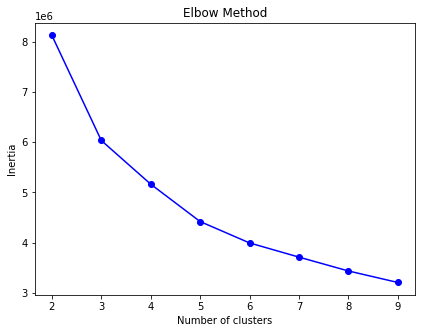

In [ ]:
# Determining the optimal number of clusters using elbow method and silhouette scores
inertia_list = []
silhouette_scores_list = []
cluster_range = range(2, 10)  # Testing for 2 to 10 clusters

# Calculating inertia and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled1)
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    #silhouette_scores_list.append(silhouette_score(features_scaled0, labels))

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_list, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
